# Sweeps in 1000 genomes male X haplotypes

In [2]:
import os, sys, math, re
from pathlib import Path
import numpy
import pandas as pd
import pandas as pandas
import numpy as np
from pandas import DataFrame, Series
from sklearn.decomposition import PCA

numpy.random.seed(7)

Import variables global to the entire analysis:

In [3]:
import analysis_globals as ag

Local code in the scripts dir on the cluster:

In [4]:
if str(ag.scripts_dir) not in sys.path:
    sys.path.append(str(ag.scripts_dir))

from hg19_chrom_sizes import hg19_chrom_sizes

Plotting setup:

In [5]:
%matplotlib inline

# Make inline plots vector graphics instead of raster graphics
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina', 'png')

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
# from mpl_toolkits.basemap import Basemap
#matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

import mpld3

import seaborn as sns
sns.set() # seaborn niceness
sns.set_style("whitegrid")
sns.set_context("paper")

# lowess for plotting
from statsmodels.nonparametric.smoothers_lowess import lowess

def stairs(df, start='start', end='end', pos='pos', endtrim=0):
    "Turn a df with start, end into one with pos to plot as stairs"
    df1 = df.copy(deep=True)
    df2 = df.copy(deep=True)
    df1[pos] = df1[start]
    df2[pos] = df2[end] - endtrim
    return pd.concat([df1, df2]).sort_values([start, end])

Ignore warnings:

In [6]:
# silence deprecation warnings (lots from seaborn)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=numpy.VisibleDeprecationWarning)

Analysis dirs:

In [7]:
root_dir = Path(os.environ['HOME'], 'simons/faststorage/people/kmt')
meta_data_dir = Path(os.environ['HOME'], 'simons/faststorage/data/metadata')
steps_dir = root_dir / 'steps'
argweaver_dir = steps_dir / 'argweaver/output'
results_dir = root_dir / 'results'
figures_dir = root_dir / 'figures'
data_dir = root_dir / 'data'
pi_dir = steps_dir / 'pi_stores'
dist_dir = steps_dir / 'dist_stores'
#pi_dir = root_dir / 'old_pi_stores'
male_x_haploid_dir = steps_dir / 'male_x_haploids'

Local code in the scripts dir on the cluster:

In [8]:
scripts_dir = root_dir / 'scripts'
if str(scripts_dir) not in sys.path:
    sys.path.append(str(scripts_dir))

import simons_meta_data
import hg19_chrom_sizes

from toggle_code_and_errors import toggle_code_html, toggle_errors_html

Import variables global to the entire analysis:

In [9]:
import analysis_globals

## Convenience functions

In [10]:
def silent_nanmean(x):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return numpy.nanmean(x)
    
def ident_scalar(s):
    x = s.unique()
    assert(len(x)) == 1, x
    return x[0]

from multiprocessing import Pool, cpu_count

# def cpu_count():
#     return int(os.environ['SLURM_CPUS_PER_TASK'])

def parallel_apply(grouped, func, *args, chunksize=None):
    names, groups = zip(*grouped)
    arg_iter = zip(groups, *[[x]*len(groups) for x in args])
    
    slurm_cores = os.environ.get('SLURM_JOB_NUM_NODES')
    nr_cpu = slurm_cores and int(slurm_cores) or cpu_count()

    with Pool(nr_cpu) as p:
        l = p.starmap(func, arg_iter, chunksize=chunksize)
        
    df = pandas.concat(l, keys=names)
    df.reset_index(level=df.index.nlevels-1, drop=True, inplace=True)
    return df

## Load meta data

In [11]:
# easy loading of meta data in a consistent manner across code
individuals, populations, regions = simons_meta_data.get_meta_data(meta_data_dir=meta_data_dir)

pop_categories = pandas.read_hdf(str(results_dir / 'population_categories.store'), 'sr')
region_categories = pandas.read_hdf(str(results_dir / 'region_categories.store'), 'sr')
# region_colors = dict(zip(list(region_categories), 
#                          ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', 
#                           '#ff7f00', '#ffff33', '#a65628']))

region_colors = dict(zip(list(region_categories), 
                         ['#e41a1c', '#377eb8',  '#984ea3', '#4daf4a',
                          '#ff7f00', '#ffff33', '#a65628']))

chromosome_lengths = dict((k.replace('chr', ''), v) for k, v in hg19_chrom_sizes.hg19_chrom_sizes.items())

## Load sweep data

In [12]:
! ls ../steps/1000genomes/male_dist_admix_masked_stores/X/CEU/5e-05/

clique_data_5e-05_25%.hdf  clique_data_5e-05_35%.hdf  clique_data_5e-05_45%.hdf
clique_data_5e-05_30%.hdf  clique_data_5e-05_40%.hdf  clique_data_5e-05_50%.hdf


In [13]:
clique_data_file_name = '../steps/1000genomes/male_dist_admix_masked_stores/X/CEU/5e-05/clique_data_5e-05_50%.hdf'
sweep_data = pandas.read_hdf(clique_data_file_name)

# remove echs in pars if any
sweep_data = sweep_data.loc[(sweep_data.start > 2699520) & (sweep_data.end < 154931044)]

sweep_data.head()

,indiv_1,start,end,mean_dist,mean_dist_af,win_swept,win_swept_af,prop_indivs_missing,called,clade_size,clade_mean_dist,called_af,clade_size_af,clade_mean_dist_af,run_id,run_length,swept,run_id_af,run_length_af,swept_af
27,NA06984,2700000,2800000,0.000616,0.000616,False,False,0.0,False,NaN,NaN,False,NaN,NaN,3,180,False,3,180,False
28,NA06984,2800000,2900000,0.000296,0.000296,False,False,0.0,False,NaN,NaN,False,NaN,NaN,3,180,False,3,180,False
29,NA06984,2900000,3000000,0.000296,0.000296,False,False,0.0,False,NaN,NaN,False,NaN,NaN,3,180,False,3,180,False
30,NA06984,3000000,3100000,0.000551,0.000551,False,False,0.0,False,NaN,NaN,False,NaN,NaN,3,180,False,3,180,False
31,NA06984,3100000,3200000,0.001141,0.001141,False,False,0.0,False,NaN,NaN,False,NaN,NaN,3,180,False,3,180,False


## Windows where distances to other individuals are incompletely known

100kb windows:

In [14]:
print('Max proportion of uncalled individuals:', analysis_globals.max_prop_indiv_missing)

Max proportion of uncalled individuals: 0.1


In [15]:
sweep_data.prop_indivs_missing.describe()

count    74578.000000
mean         0.097240
std          0.296287
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: prop_indivs_missing, dtype: float64

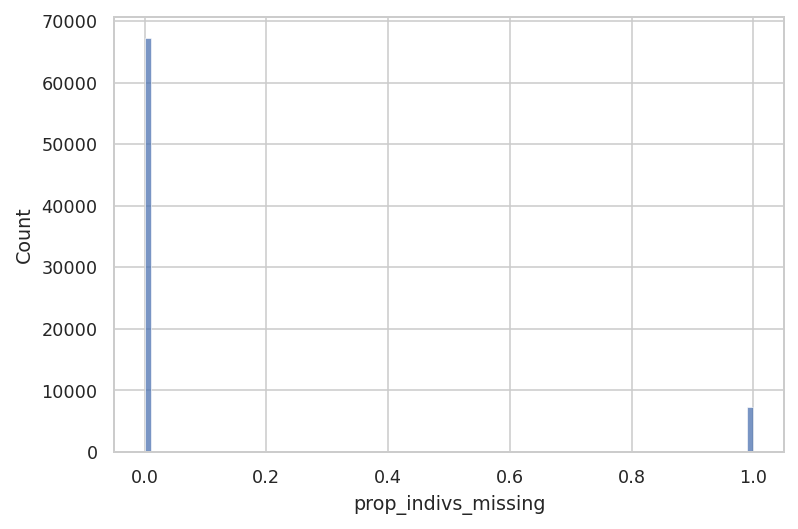

In [16]:
g = sns.histplot(sweep_data.prop_indivs_missing, bins=100)

In [17]:
missing_indiv_window_mask = sweep_data.prop_indivs_missing <= analysis_globals.max_prop_indiv_missing
print('Proportion of 100kb windows left after filtering:', missing_indiv_window_mask.sum() / missing_indiv_window_mask.size)

sweep_data['not_missing'] = missing_indiv_window_mask

Proportion of 100kb windows left after filtering: 0.9027595269382391


## Proportion of missing windows across chromosome

In [18]:
missing_windows = (sweep_data
                            .groupby(['start', 'end'])['prop_indivs_missing']
                            .mean()
                            .reset_index()
                            .rename(columns={'prop_indivs_missing': 'mean_prop_indivs_missing'})
                           )
missing_windows['is_missing'] = missing_windows.mean_prop_indivs_missing >= analysis_globals.max_prop_indiv_missing

Write missing windows to hdf:

In [19]:
missing_windows.to_hdf(results_dir / 'missing_windows_ceu.hdf', 'df', format='table', mode='w')
missing_windows.head()

,start,end,mean_prop_indivs_missing,is_missing
0,2700000,2800000,0.0,False
1,2800000,2900000,0.0,False
2,2900000,3000000,0.0,False
3,3000000,3100000,0.0,False
4,3100000,3200000,0.0,False


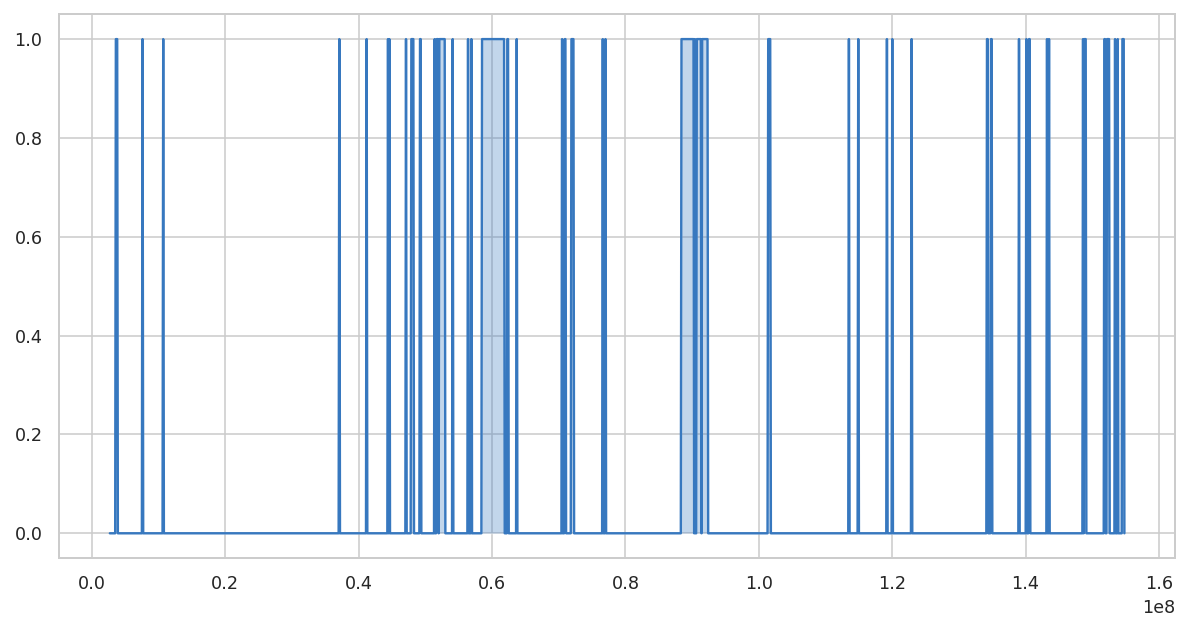

In [20]:
with sns.xkcd_palette(["windows blue", "amber", "greyish", "faded green", "dusty purple"]):
    fig, ax = plt.subplots(figsize=(10, 5))
    g = ax.plot(missing_windows.start, missing_windows.mean_prop_indivs_missing)
    g = ax.fill_between(missing_windows.start, missing_windows.mean_prop_indivs_missing, alpha=0.3)

In [21]:
missing_windows.head()

,start,end,mean_prop_indivs_missing,is_missing
0,2700000,2800000,0.0,False
1,2800000,2900000,0.0,False
2,2900000,3000000,0.0,False
3,3000000,3100000,0.0,False
4,3100000,3200000,0.0,False


## Consequtive regions with missing data

Run id for windows with missing/non-missing status:

In [22]:
def run_id(sr):
    return (sr != sr.shift()).cumsum()

missing_windows['missing_status_run_id'] = run_id(missing_windows.is_missing)

For each individual compute how big a run of non-missing windows that window is part of:

In [23]:
missing_windows['missing_status_run_length'] = (missing_windows
                                 .groupby(['missing_status_run_id'])['missing_status_run_id']
                                 .transform(numpy.size)
                                )
missing_windows.head()

,start,end,mean_prop_indivs_missing,is_missing,missing_status_run_id,missing_status_run_length
0,2700000,2800000,0.0,False,1,9
1,2800000,2900000,0.0,False,1,9
2,2900000,3000000,0.0,False,1,9
3,3000000,3100000,0.0,False,1,9
4,3100000,3200000,0.0,False,1,9


Get start end coordinates of each region:

In [24]:
missing_regions = (missing_windows
                   .groupby(['missing_status_run_id', 'is_missing'])
                   .aggregate({'start': 'min', 'end': 'max'})
                   .reset_index()
                  )
missing_regions.head()

,missing_status_run_id,is_missing,start,end
0,1,False,2700000,3600000
1,2,True,3600000,3900000
2,3,False,3900000,7600000
3,4,True,7600000,7700000
4,5,False,7700000,10700000


In [25]:
missing_regions.to_hdf(results_dir / 'missing_regions_ceu.hdf', 'df', format='table', mode='w')

## Impact of missing data on sweep calling

To what extent is missing data responsible for what we call as swept.

It is possible that some regions of the chromsome are without sweeps simply because these regions have more missing data, so a run of sweep clade windows cannot be called. 

In [26]:
plot_df = (sweep_data[['start', 'end', 'swept']]
           .merge(missing_windows[['start', 'end', 'is_missing', 'missing_status_run_length']], 
                  on=['start', 'end'], how='left')
        )
plot_df.head()

,start,end,swept,is_missing,missing_status_run_length
0,2700000,2800000,False,False,9
1,2800000,2900000,False,False,9
2,2900000,3000000,False,False,9
3,3000000,3100000,False,False,9
4,3100000,3200000,False,False,9


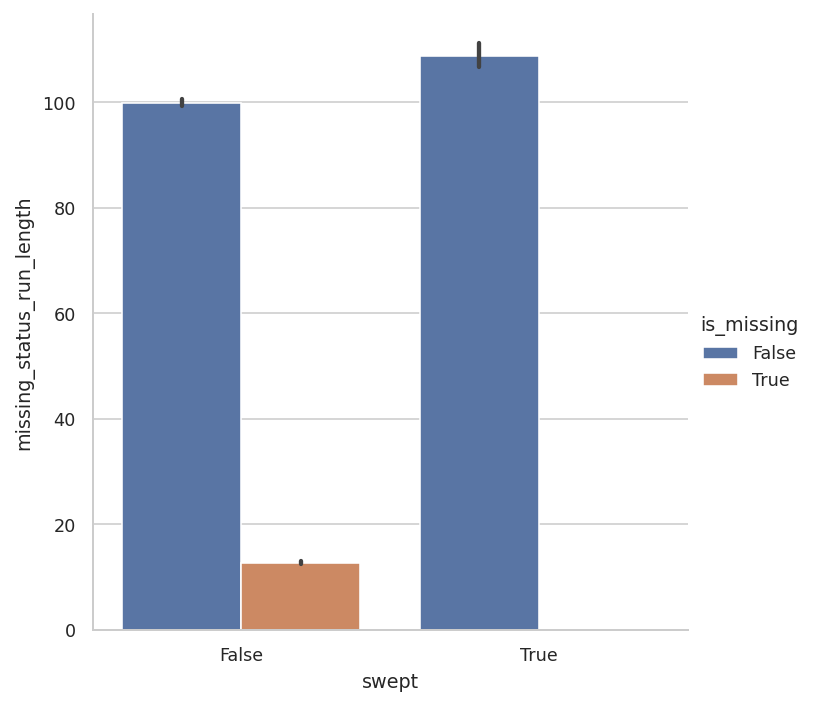

In [27]:
g = sns.catplot(x='swept', y='missing_status_run_length', hue='is_missing', kind='bar', data=plot_df)

Windows called as swept are part of longer consequeitvely called regions than windows not called as swept. 
That could simply be becuase we demand that swept regions are always at least 500kb.

A better way to address the impact of missing data on the distribuion of swept windows across the chromosome, would be to see if windows called as `sweep_clade` are more often in non-missing regions larger than 500kb:

In [28]:

plot_df = (sweep_data[['start', 'end', 'win_swept']]#'sweep_clade']]
           .merge(missing_windows[['start', 'end', 'is_missing', 'missing_status_run_length']], 
                  on=['start', 'end'], how='left')
#           .loc[lambda df: df.is_missing == False]
           .assign(above_length_thresh = lambda df: df.missing_status_run_length >= analysis_globals.min_run_length)
        )
plot_df.head()


,start,end,win_swept,is_missing,missing_status_run_length,above_length_thresh
0,2700000,2800000,False,False,9,True
1,2800000,2900000,False,False,9,True
2,2900000,3000000,False,False,9,True
3,3000000,3100000,False,False,9,True
4,3100000,3200000,False,False,9,True


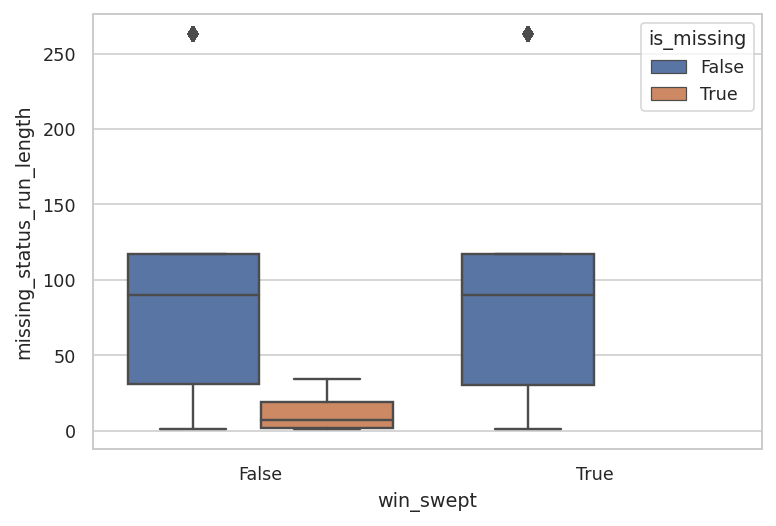

In [29]:
#sns.boxplot(x="sweep_clade", y="missing_status_run_length", hue='is_missing', data=plot_df)
sns.boxplot(x="win_swept", y="missing_status_run_length", hue='is_missing', data=plot_df) ;

It does seem that the run length of non-missing windows is not smaller for windows that are not in a sweep clade. In addition the mean length of non-missing regions is larger than 100, I.e. *much* larger than 5 (500kb)

## Start end coordinates of each swept haplotype

In [30]:
# now you can easily get the intervals for each swept haplotype
sweep_coord = (sweep_data
               .loc[sweep_data.swept == True]
               .groupby(['indiv_1', 'run_id'])
               .aggregate({'start': 'min', 'end': 'max', 'mean_dist': 'mean'})
               .reset_index(level=['indiv_1', 'run_id'])
              )
#sweep_coord.to_hdf(results_dir / f'sweep_coord_{ech_calling_tag}.hdf', 'df', format='table', mode='w')

sweep_coord_af = (sweep_data
               .loc[sweep_data.swept_af == True]
               .groupby(['indiv_1', 'run_id'])
               .aggregate({'start': 'min', 'end': 'max', 'mean_dist': 'mean'})
               .reset_index(level=['indiv_1', 'run_id'])
              )
#sweep_coord_af.to_hdf(results_dir / f'sweep_coord_af_{ech_calling_tag}.hdf', 'df', format='table', mode='w')

## Map of all swept haplotypes

In [31]:
all_indivduals = sweep_data.indiv_1.unique()

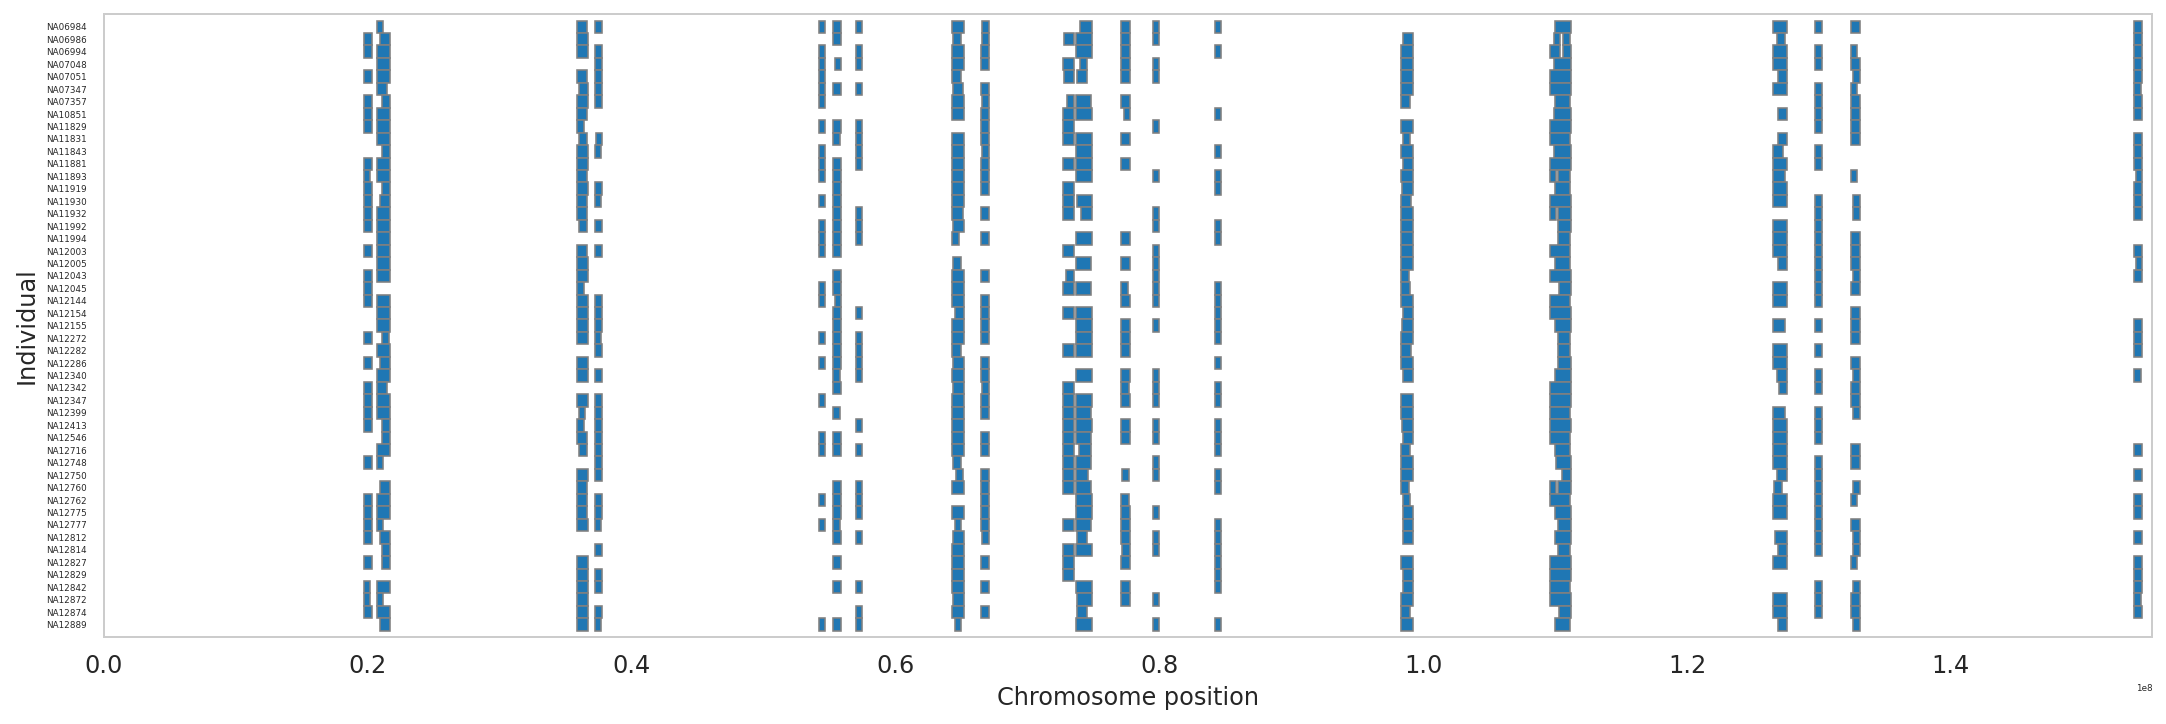

In [32]:
# turn indiv_1 into category with levels including any with no sweeps, and a corresponding int
plot_df = (sweep_coord
           .assign(indiv_1 = pandas.Categorical(sweep_coord.indiv_1,
                                                   categories=all_indivduals.tolist(),
                                                   ordered=True))
           .assign(indiv_code = lambda df: df.indiv_1.cat.codes)
          )

with sns.plotting_context('paper', font_scale=0.5):
    with sns.axes_style("whitegrid", {'axes.grid' : False}):
        fig, ax = plt.subplots(figsize=(15,5))
        ax.set_xlim([0, chromosome_lengths['X']])
        ax.set_ylim([-1, len(all_indivduals)])
        labs = pandas.Categorical(all_indivduals,
                           categories=all_indivduals,
                           ordered=True)
        
        plt.yticks(range(len(all_indivduals)), reversed(all_indivduals.tolist()))

        for segm in plot_df.itertuples():            
            y = len(all_indivduals) - segm.indiv_code - 1
            g = ax.add_patch(Rectangle((segm.start, y-0.5), segm.end-segm.start, 1, 
                                        facecolor='tab:blue', edgecolor='grey'))

        for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(12) 
            
        plt.xlabel('Chromosome position', fontsize=12)
        plt.ylabel('Individual', fontsize=12)

        plt.tight_layout()
        
#        plt.savefig(str(figures_dir / f'swept_male_haplotypes_map_chrX_clean_{ech_calling_tag}.pdf'))

In [33]:
def stairs(df, start='start', end='end', pos='pos', endtrim=0):
    "Turn a df with start, end into one with pos to plot as stairs"
    df1 = df.copy(deep=True)
    df2 = df.copy(deep=True)
    df1[pos] = df1[start]
    df2[pos] = df2[end] - endtrim
    return pandas.concat([df1, df2]).sort_values([start, end])

In [34]:
total_swept = (sweep_data.loc[sweep_data.not_missing]
           .groupby(['start', 'end'])['swept']
#           .groupby(['start', 'end'])['swept']
           .aggregate(['sum', 'size'])
           .rename(columns={'sum': 'nr_swept', 'size': 'total'})
           .reset_index()
           .assign(pos = lambda df: df.start + (df.end - df.start) / 2,
                   prop_swept = lambda df: df.nr_swept / df.total)
          )
total_swept.head()

,start,end,nr_swept,total,pos,prop_swept
0,2700000,2800000,0,49,2750000.0,0.0
1,2800000,2900000,0,49,2850000.0,0.0
2,2900000,3000000,0,49,2950000.0,0.0
3,3000000,3100000,0,49,3050000.0,0.0
4,3100000,3200000,0,49,3150000.0,0.0


In [35]:
sweep_peaks = pd.read_hdf("../results/sweep_peaks_5e-05_25%.hdf")
sweep_peaks.head()

,start,end,prop_swept,pos
run_id,,,,
1,19800000,19900000,0.828571,19850000.0
2,21200000,21300000,0.814286,21250000.0
3,36200000,36400000,0.664286,36300000.0
4,37300000,37700000,0.507143,37500000.0
5,49500000,50000000,0.528571,49750000.0


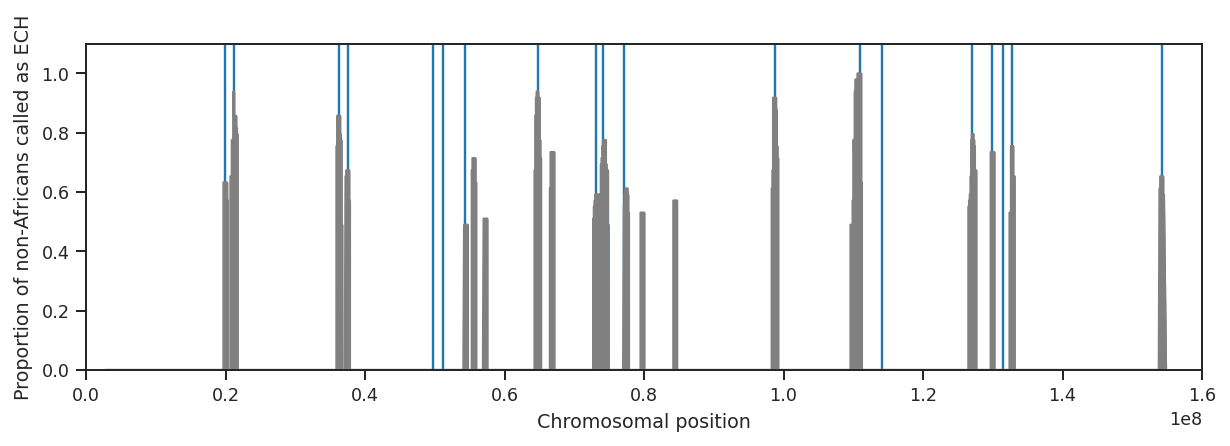

In [36]:
with sns.axes_style('ticks'):
    plt.figure(figsize=(10, 3))
    plt.xlim(0,160e6)
    plt.ylim(0, 1.1)
    plot_df = stairs(total_swept)
    plt.plot(plot_df.pos, plot_df.prop_swept, color='gray')
    plt.fill_between(plot_df.pos, 0, plot_df.prop_swept, alpha=1, zorder=1, color='gray')
    plt.ylabel('Proportion of non-Africans called as ECH')
    plt.xlabel('Chromosomal position');
    [plt.axvline(x, color='tab:blue', zorder=0) for x in sweep_peaks.pos] ;

    plt.savefig(str(ag.figures_dir / "ceu_ech_peaks.pdf"), bbox_inches='tight')
    plt.savefig(str(ag.figures_dir / "ceu_ech_peaks.png"), bbox_inches='tight')    

- Very good overlap 15/19 (4 simons not found, and 5 unique to CEU)
- Suggests peaks are mostly built in the 10,000 year interval with additional recent coalescences within CEU


## Proportion of chromosomal windows with at least one ECH

Not counting windows with too many missing pairwise differences:

In [37]:
nr_ech_chr_wins = sweep_data.loc[(sweep_data.swept == True) & sweep_data.not_missing, 'start'].unique().size
nr_chr_wins = sweep_data.loc[sweep_data.not_missing, 'start'].unique().size
nr_ech_chr_wins, nr_chr_wins, nr_ech_chr_wins / nr_chr_wins

(152, 1374, 0.11062590975254731)

Counting all of the analyzed chromosome:

In [38]:
nr_ech_chr_wins = sweep_data.loc[sweep_data.swept == True, 'start'].unique().size
nr_chr_wins = sweep_data.loc[:, 'start'].unique().size
nr_ech_chr_wins, nr_chr_wins, nr_ech_chr_wins / nr_chr_wins

(152, 1522, 0.09986859395532194)

and confidence interval (assuming independence of 100kb windows)

In [39]:
# from statsmodels.stats.proportion import proportion_confint
# proportion_confint(count=nr_ech_chr_wins, nobs=nr_chr_wins)

## Proportion 100kb haplotypes windows called as ECH

Not counting windows with too many missing pairwise differences:

In [40]:
nr_ech_chr_wins = sweep_data.loc[(sweep_data.swept == True) & sweep_data.not_missing, 'start'].size
nr_chr_wins = sweep_data.loc[sweep_data.not_missing, 'start'].size
nr_ech_chr_wins, nr_chr_wins, nr_ech_chr_wins / nr_chr_wins

(5175, 67326, 0.07686480705819446)

In [40]:
nr_ech_chr_wins = sweep_data.loc[(sweep_data.swept == True), 'start'].size
nr_chr_wins = sweep_data.loc[:, 'start'].size
nr_ech_chr_wins, nr_chr_wins, nr_ech_chr_wins / nr_chr_wins

(5175, 74578, 0.06939043685805465)

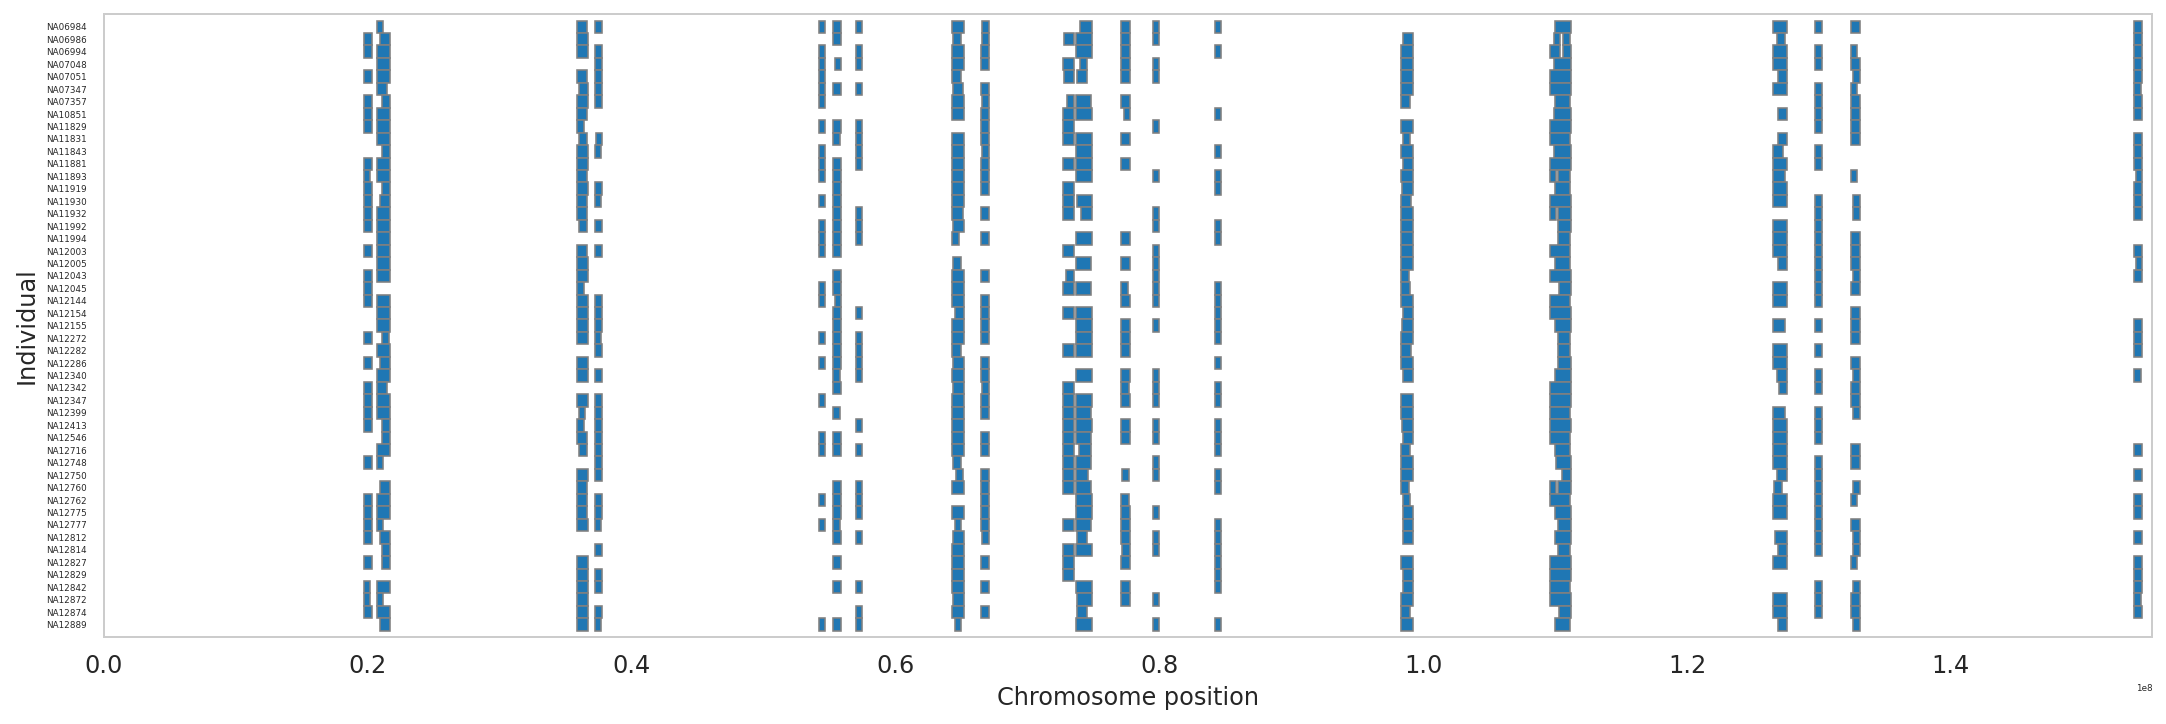

In [40]:
# turn indiv_1 into category with levels including any with no sweeps, and a corresponding int
plot_df = (sweep_coord_af
           .assign(indiv_1 = pandas.Categorical(sweep_coord.indiv_1,
                                                   categories=all_indivduals.tolist(),
                                                   ordered=True))
           .assign(indiv_code = lambda df: df.indiv_1.cat.codes)
          )

with sns.plotting_context('paper', font_scale=0.5):
    with sns.axes_style("whitegrid", {'axes.grid' : False}):
        fig, ax = plt.subplots(figsize=(15,5))
        ax.set_xlim([0, chromosome_lengths['X']])
        ax.set_ylim([-1, len(all_indivduals)])
        labs = pandas.Categorical(all_indivduals,
                           categories=all_indivduals,
                           ordered=True)
        
        plt.yticks(range(len(all_indivduals)), reversed(all_indivduals.tolist()))

        for segm in plot_df.itertuples():            
            y = len(all_indivduals) - segm.indiv_code - 1
            g = ax.add_patch(Rectangle((segm.start, y-0.5), segm.end-segm.start, 1, 
                                        facecolor='tab:blue', edgecolor='grey'))

        for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(12) 
            
        plt.xlabel('Chromosome position', fontsize=12)
        plt.ylabel('Individual', fontsize=12)

        plt.tight_layout()
        
#        plt.savefig(str(figures_dir / f'swept_male_haplotypes_map_chrX_clean_{ech_calling_tag}.pdf'))

# OLD

------

### Load data

In [13]:

df_list = list()

for chrom in ['X', '2']:

    for tup in ag.g1000_pop_info.itertuples():
    
    
    
        #####################################
        if not tup.population == 'CHB':
            continue
        #####################################
        
        dir_path = ag.steps_dir / '1000genomes' / 'male_dist_admix_masked_stores' / chrom / tup.population / '5-e05'
        print(dir_path)
        for path in dir_path.glob('sweep_data_*.hdf'):
            dist_cut, clade_cut = map(float, re.search(r'sweep_data_([^_]+)_([^_]+)%.hdf', path.name).groups())
            clade_cut /= 100
            df = pd.read_hdf(path)
            df['dist_cut'] = dist_cut
            df['clade_cut'] = clade_cut
            df['chrom'] = chrom
            df['population'] = tup.population
            df['superpop'] = tup.superpop
            df_list.append(df)
    
sweep_data = pd.concat(df_list)

sweep_data['superpop'] = pd.Categorical(sweep_data.superpop, 
                                        categories=['AFR', 'EUR', 'SAS', 'EAS', 'AMR'], 
                                        ordered=True)
sweep_data.head()


ValueError: No objects to concatenate

In [9]:
subset_df = sweep_data.loc[(sweep_data.dist_cut == 5e-5) & (sweep_data.chrom == 'X') & (sweep_data.population == 'CHB')]

In [12]:
def get_best_sweep_call(grp):

    if grp.swept.sum():
        return grp.loc[(grp.swept == True) & (grp.clade_cut == grp.clade_cut.max())]
    else:
        return grp.loc[grp.clade_cut == grp.clade_cut.min()]

df = subset_df.groupby(['chrom', 'population', 'start']).apply(get_best_sweep_call).reset_index(drop=True)
df.head()


,indiv_1,start,end,mean_dist,mean_dist_af,prop_indivs_missing,win_swept,win_swept_af,called,called_af,...,run_length,swept,run_id_af,run_length_af,swept_af,dist_cut,clade_cut,chrom,population,superpop
0,NA18530,0,100000,NaN,NaN,1.0,True,True,False,False,...,22,False,1,22,False,0.00005,0.0,X,CHB,EAS
1,NA18534,0,100000,NaN,NaN,1.0,True,True,False,False,...,22,False,1,22,False,0.00005,0.0,X,CHB,EAS
2,NA18536,0,100000,NaN,NaN,1.0,True,True,False,False,...,22,False,1,22,False,0.00005,0.0,X,CHB,EAS
3,NA18543,0,100000,NaN,NaN,1.0,True,True,False,False,...,22,False,1,22,False,0.00005,0.0,X,CHB,EAS
4,NA18544,0,100000,NaN,NaN,1.0,True,True,False,False,...,22,False,1,22,False,0.00005,0.0,X,CHB,EAS


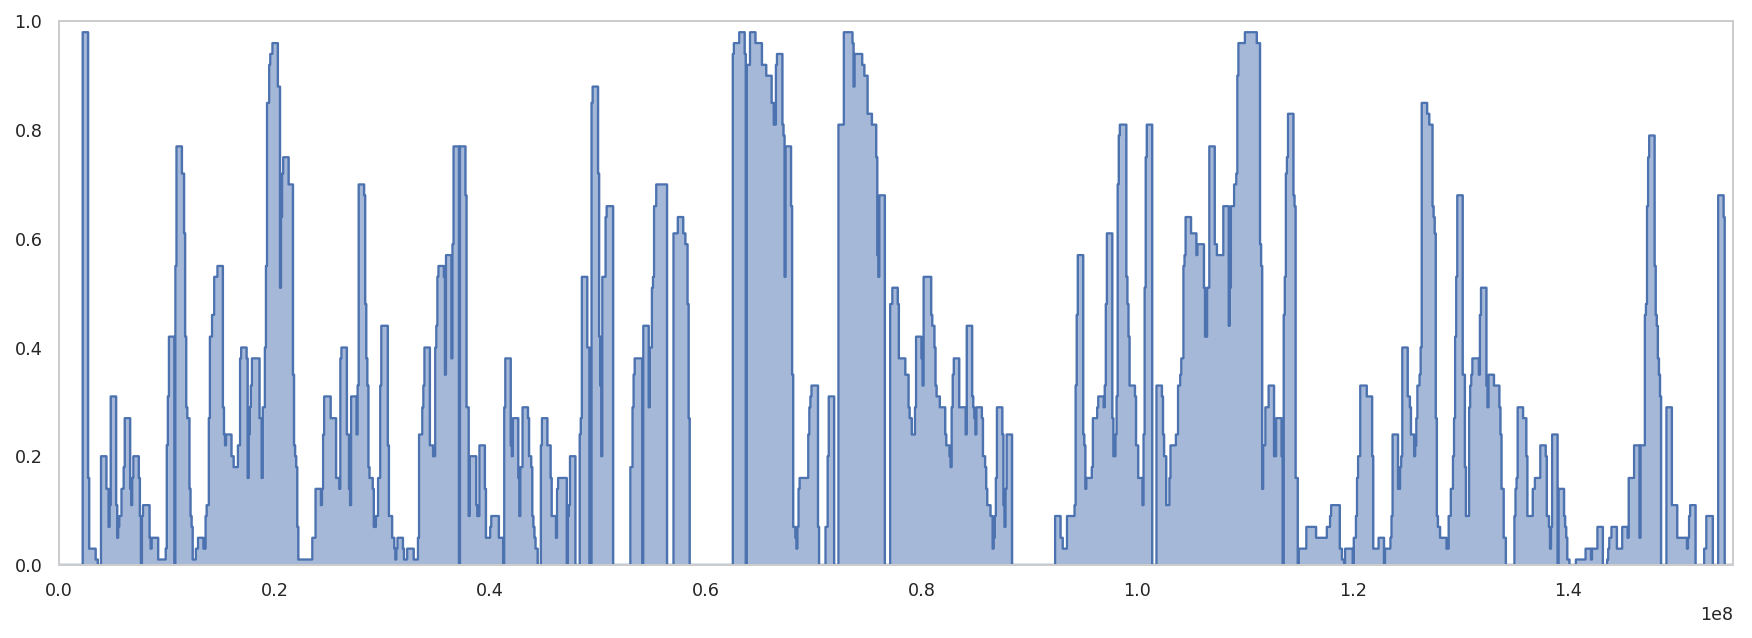

In [10]:
def filter_func(grp):

    cols = ['chrom', 'population', 'start', 'end', 'clade_cut']
    
    df = grp.loc[grp.swept == True]
    if not len(df):
        return grp.loc[grp.clade_cut == grp.clade_cut.min(), cols].iloc[0]
    return df.loc[df.clade_cut == df.clade_cut.max(), cols].iloc[0]

test_df = subset_df.groupby(['chrom', 'population', 'start']).apply(filter_func).reset_index(drop=True)


with sns.axes_style("whitegrid", {'axes.grid' : False}):

    fig, ax = plt.subplots(1, 1, figsize=(15, 5),                      
                             subplot_kw={'xlim':(0, hg19_chrom_sizes['chrX']),
                                         'ylim':(0, 1)})
    
    df = stairs(test_df)
    ax.plot(df.pos, df.clade_cut)
    ax.fill_between(df.pos, df.clade_cut, alpha=0.5)



... shows the proportion of individuals that across 500kb has a mutual distance below cutoff.

In [ ]:
plot_df = (subset_df
           .groupby(['chrom', 'clade_cut', 'start', 'end', 'superpop', 'population'])['swept']
           .aggregate(['sum', 'size'])
           .rename(columns={'sum': 'nr_swept', 'size': 'total'})
           .reset_index()
           .assign(prop_swept=lambda df: df.nr_swept / df.total)
          )
plot_df.head()

In [ ]:
colormap = matplotlib.cm.get_cmap('PuRd', 100)

n_subplots = sweep_data.clade_cut.unique().size

from mpl_toolkits.axes_grid1 import make_axes_locatable


with sns.axes_style("whitegrid", {'axes.grid' : False}):

    fig, ax = plt.subplots(1, 1, figsize=(15, 5),                      
                             subplot_kw={'xlim':(0, hg19_chrom_sizes['chrX']),
                                         'ylim':(0, 1)})
#     ax.set_facecolor('black')
    
    for clade_cut, call_df in plot_df.groupby('clade_cut'):
        
#         if clade_cut < 0.5:
#             continue

        df = stairs(call_df)
        ax.fill_between(df.pos, df.prop_swept, color=colormap(clade_cut), linewidth=0.0)

    divider = make_axes_locatable(plt.gca())
    ax_cb = divider.new_horizontal(size="2%", pad=0.25)    
    cb1 = matplotlib.colorbar.ColorbarBase(ax_cb, cmap=colormap, orientation='vertical')
    plt.gcf().add_axes(ax_cb)

    plt.tight_layout()



In [ ]:
n_subplots = sweep_data.clade_cut.unique().size

with sns.axes_style("whitegrid", {'axes.grid' : False}):

    fig, axes = plt.subplots(n_subplots, 1, sharey=True, sharex=True, figsize=(15, 100),                      
                             subplot_kw={'xlim':(0, hg19_chrom_sizes['chrX']),
                                         'ylim':(0, 1)})

    for ax, (clade_cut, call_df) in zip(axes, plot_df.groupby('clade_cut')):
        
        ax.set_title("{:.0f}%".format(clade_cut*100), loc='left', fontsize=10)

        df = call_df.copy()
        df.loc[df.prop_swept < clade_cut, 'prop_swept'] = 0

        df = stairs(df)
        ax.plot(df.pos, df.prop_swept, label='population')
        ax.legend(loc='upper right')

        ax.axhline(clade_cut, color='black', linestyle='dashed')
        
    plt.tight_layout()


In [ ]:
df_list = list()
for chrom in ['X']:
    for tup in ag.g1000_pop_info.itertuples():
        df = pd.read_hdf(ag.steps_dir / '1000genomes' / \
                'male_dist_admix_masked_stores' / chrom / tup.population / 'sweep_data_5e-05_30%.hdf')
        df['chrom'] = chrom
        df['population'] = tup.population
        df['superpop'] = tup.superpop
        df_list.append(df)
    
sweep_data = pd.concat(df_list)

sweep_data['superpop'] = pd.Categorical(sweep_data.superpop, 
                                        categories=['AFR', 'EUR', 'SAS', 'EAS', 'AMR'], 
                                        ordered=True)
sweep_data.head()

# Mask for missing data and PARs and add columns such as never_swept...

In [ ]:
ag.g1000_pop_info.style.set_properties(**{'text-align': 'left'})

## Missing regions

## Stats on sweeps

In [ ]:
sr = sweep_data.groupby('population').apply(lambda df: df.indiv_1.unique().size)
sns.barplot(sr, sr.index)


## Proportion swept

In [ ]:
# group by start, end, region and compute size
plot_df = (sweep_data
           .groupby(['start', 'end', 'superpop', 'population'])['swept']
           .aggregate(['sum', 'size'])
           .rename(columns={'sum': 'nr_swept', 'size': 'total'})
           .reset_index()
           .assign(prop_swept=lambda df: df.nr_swept / df.total)
          )
plot_df.head()

In [ ]:
with sns.axes_style("whitegrid", {'axes.grid' : False}):
    fig, axes = plt.subplots(5, 1, sharey=True, figsize=(15, 15),                      
                             subplot_kw={'xlim':(0, hg19_chrom_sizes['chrX']),
                                         'ylim':(0, 1)})

    for ax, (superpop, super_df) in zip(axes, plot_df.groupby('superpop')):
        ax.set_title(superpop, loc='left', fontsize=8)

        for (population, pop_df) in super_df.groupby('population'):
            df = stairs(pop_df)
            ax.plot(df.pos, df.prop_swept, label=population)
        ax.legend(loc='upper right')

    plt.tight_layout()
plt.savefig(str(ag.figures_dir / "g1000_ech.pdf"))

In [ ]:
with sns.axes_style("whitegrid", {'axes.grid' : False}):
    fig, axes = plt.subplots(26, 1, sharey=True, figsize=(13, 50),                      
                             subplot_kw={'xlim':(0, hg19_chrom_sizes['chrX']),
                                         'ylim':(0, 1)})
    for ax, population in zip(axes, ag.g1000_pop_info.population):
        df = stairs(plot_df.loc[plot_df.population == population])
        ax.plot(df.pos, df.prop_swept)
        ax.set_title(population, loc='left', fontsize=8)
    plt.tight_layout()

    

In [ ]:
with sns.axes_style("whitegrid", {'axes.grid' : False}):
    fig, axes = plt.subplots(26, 1, sharex=True, sharey=True, figsize=(10, 10),                         
                             subplot_kw={'xlim':(0, chromosome_lengths['X']),
                                         'ylim':(0, 1)})

    for ax, population in zip(axes, g1000_populations):
        df = plot_df.loc[plot_df.population == population]    
        
        for tup in df.itertuples():
            if tup.nr_swept:
                g = ax.add_patch(Rectangle((tup.start, 0), tup.end-tup.start, tup.nr_swept/tup.total, 
#                                  facecolor=region_colors[reg], 
                                 linewidth=0,
                                 #edgecolor=None,#region_colors[reg], 
                                 zorder=2))
        ax.set_title(reg, loc='left')
                
        for tup in missing_regions.loc[missing_regions.is_missing == True].itertuples():
            g = ax.add_patch(Rectangle((tup.start, 0), tup.end-tup.start, 1, 
                     facecolor='lightgray', 
                     linewidth=0,
#                     edgecolor=None,
                     alpha=0.5,
                     zorder=1))
    #     ax.set_ylim(0, df.nr_swept.max())

    plt.tight_layout()
    
    plt.savefig(str(figures_dir / "tot_swept_by_region.pdf"))
    #plt.close() # closing teh plot suppres automatic plotting without plt.show()